# Setup

## Imports

In [2]:
import os.path
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data
import torchvision.utils
from torch import nn, optim
from torch.nn import functional
from torchvision import datasets, transforms

from PIL import Image
import umap
import umap.plot

import random
from tqdm import tqdm

# Main

## Dataset

In [3]:
TRAIN_DATASET = datasets.MNIST("../../data", train=True, download=True, transform=transforms.ToTensor())
TEST_DATASET  = datasets.MNIST("../../data", train=False, download=True, transform=transforms.ToTensor())

In [4]:
# Image Getter Functions
def extract_idx(dataset, target):
    idx = (dataset.targets == target)
    res = []
    for i,v in enumerate(idx):
        if v:
            res.append(i)
    return res

def extract_idx_all(dataset):
    res = []
    for i in range(10):
        res.append(extract_idx(dataset, i))
    return res

IDX_ALL = extract_idx_all(TRAIN_DATASET)

def get_rand_img_idx(target):
    return IDX_ALL[target][random.randrange(0, len(IDX_ALL[target]))]

def get_rand_img_from_class(target, dataset=TRAIN_DATASET):
    # idx = extract_idx(dataset, target)
    # return dataset[idx[random.randrange(0,len(idx))]][0]
    return dataset[get_rand_img_idx(target)][0]

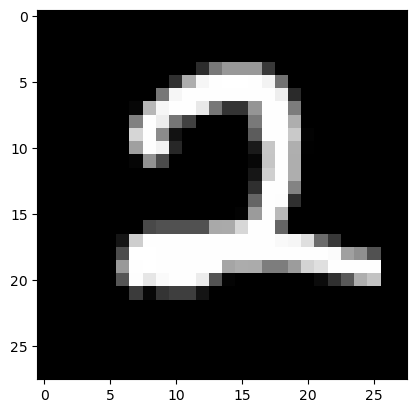

In [5]:
plt.imshow(get_rand_img_from_class(2).permute(1, 2, 0), cmap='gist_gray')

In [6]:
get_rand_img_from_class(2).permute(1, 2, 0).shape

torch.Size([28, 28, 1])

In [7]:
get_rand_img_from_class(2).shape

torch.Size([1, 28, 28])

In [8]:
def make_image(number, number_width=2):
    number = f'{number:{number_width}}'

    image_parts = []
    for char in number:
        if char == ' ':
            image_parts.append(torch.zeros((1, 28, 28)))
        else:
            image_parts.append(get_rand_img_from_class(int(char)))

    return torch.cat(image_parts, dim=2)

Shape: torch.Size([1, 28, 140])


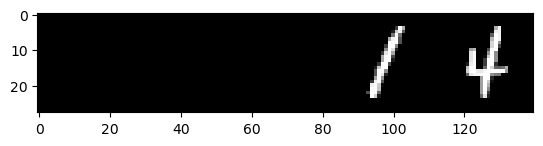

In [9]:
example = make_image(14, number_width=5)
print('Shape:', example.shape)
plt.imshow(example.permute(1, 2, 0), cmap='gist_gray');

In [10]:
def make_batch(number_max=18, number_width=2, batch_size=64, return_labels=False): # TODO was ist die laengste zahl beim addieren von n zahlen??
    images = []
    labels = []

    for _ in range(batch_size):
        random_number = random.randint(0, number_max)
        images.append(make_image(random_number, number_width=number_width))
        labels.append(random_number)
    
    if return_labels:
        return torch.stack(images), labels

    return torch.stack(images)

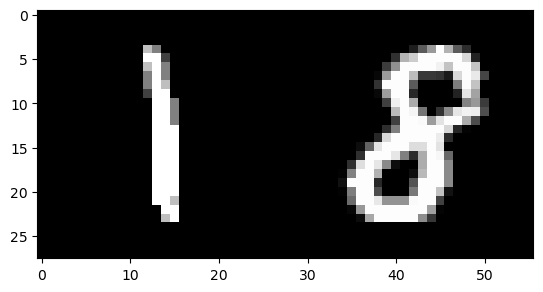

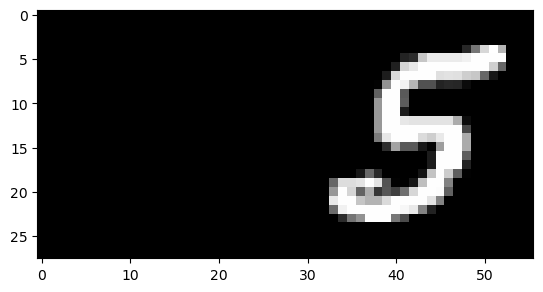

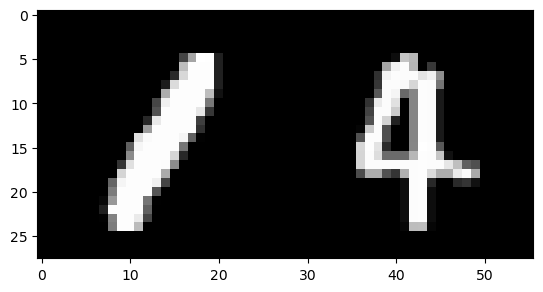

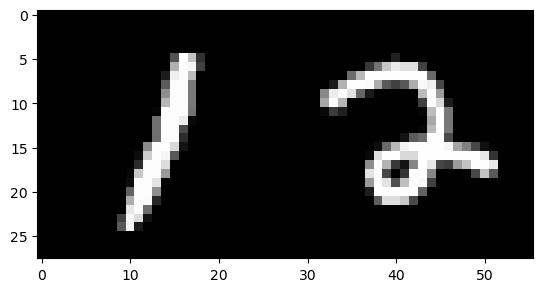

In [11]:
for example in make_batch(batch_size=4):
    plt.imshow(example.permute(1, 2, 0), cmap='gist_gray')
    plt.show()

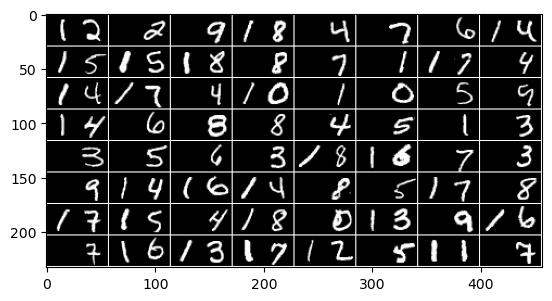

In [12]:
fixed_batch = make_batch()
grid = torchvision.utils.make_grid(fixed_batch, padding=1, pad_value=1)
plt.imshow(grid.permute(1, 2, 0), cmap='gist_gray');

## VAE Training

In [13]:
class VAE(nn.Module):
    def __init__(self, input_shape, width, latent_dimensionality):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.n_input_values = np.prod(input_shape).item()
        self.width = width
        self.latent_dimensionality = latent_dimensionality
 
        # Define encoding layers
        self.input_encoder = nn.Linear(self.n_input_values, self.width)
        self.mean_encoder = nn.Linear(self.width, self.latent_dimensionality)
        self.var_encoder = nn.Linear(self.width, self.latent_dimensionality)
 
        # Define decoding layers
        self.latent_decoder = nn.Linear(self.latent_dimensionality, self.width)
        self.final_decoder = nn.Linear(self.width, self.n_input_values)
 
    def encode(self, original):
        encoded_input = functional.relu(self.input_encoder(original))
        return (self.mean_encoder(encoded_input), self.var_encoder(encoded_input))
 
    def reparameterize(self, mean, log_variance):
        deviation = torch.exp(0.5 * log_variance)
        noise = torch.randn_like(deviation)
        return mean + noise * deviation
 
    def decode(self, latent):
        decoded_latent = functional.relu(self.latent_decoder(latent))
        final = self.final_decoder(decoded_latent)
        return final.view(-1, *self.input_shape)
 
    def forward(self, original):
        mean, log_variance = self.encode(original.view(-1, self.n_input_values))
        latent = self.reparameterize(mean, log_variance)
        decoded = self.decode(latent)
        return decoded, mean, log_variance
 
    def variational_loss_function(self, decoded, original, mean, log_variance) -> torch.Tensor:
        entropy = functional.mse_loss(decoded, original.view(-1, *self.input_shape), reduction="sum")
        divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
        return entropy + divergence

In [14]:
def train_vae(batch_count, batch_size=64, learning_rate=1e-3, width=800, latent_dimensionality=40): # TODO generalisieren auf number_width
    
    # Create a fixed batch for visualization
    fixed_batch = make_batch()
    grid = torchvision.utils.make_grid(fixed_batch, padding=1, pad_value=1)
    torchvision.utils.save_image(grid, 'images/original.png')

    # Create a random noise vector for visualization of generated numbers
    fixed_latent = torch.randn([batch_size, latent_dimensionality])

    # Create model
    model = VAE(input_shape=fixed_batch.shape[1:], width=width, latent_dimensionality=latent_dimensionality)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Save loss values for analysing
    loss_list = []

    # Start training
    for _ in tqdm(range(batch_count)):
        batch = make_batch(batch_size=batch_size)

        optimizer.zero_grad()
        reconstruction, mean, log_variance = model(batch)
        
        loss = model.variational_loss_function(reconstruction, batch, mean, log_variance)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
    
    # Show results
    model.eval()

    # Fixed Batch
    reconstruction, _, _ = model(fixed_batch)
    grid = torchvision.utils.make_grid(reconstruction, padding=1, pad_value=1)
    torchvision.utils.save_image(grid, 'images/reconstructed.png')

    # Random Latent
    random_decoded = model.decode(fixed_latent)
    grid = torchvision.utils.make_grid(random_decoded, padding=1, pad_value=1)
    torchvision.utils.save_image(grid, 'images/random.png')
    
    return model, loss_list

In [15]:
model_vae, loss_list = train_vae(6_000, latent_dimensionality=10)

100%|██████████| 6000/6000 [05:00<00:00, 19.95it/s]


<AxesSubplot:>

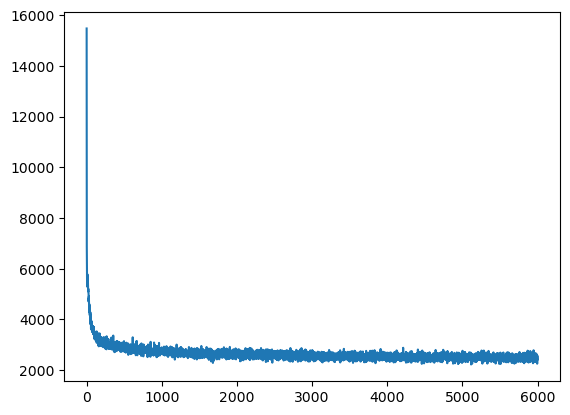

In [16]:
pd.Series(torch.tensor(loss_list)).plot()

Original


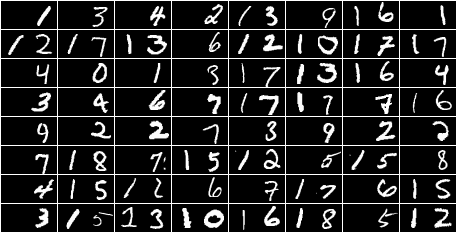

Reconstruction


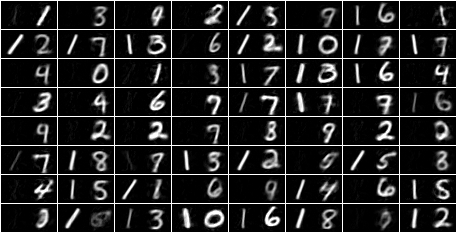

Random


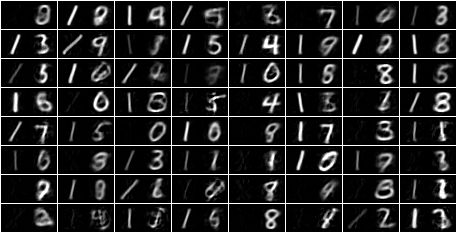

In [17]:
print('Original')
with open('./images/original.png', 'rb') as f:
    display(Image.open(f))
print('Reconstruction')
with open('./images/reconstructed.png', 'rb') as f:
    display(Image.open(f))
print('Random')
with open('./images/random.png', 'rb') as f:
    display(Image.open(f))

## UMAP Visualization

In [18]:
image_dataset, label_dataset = make_batch(batch_size=60_000, return_labels=True)

In [19]:
latent_repr, _ = model_vae.encode(image_dataset.view(-1, np.prod(image_dataset.shape[1:]).item()))
print(latent_repr.shape)

torch.Size([60000, 10])


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot:>

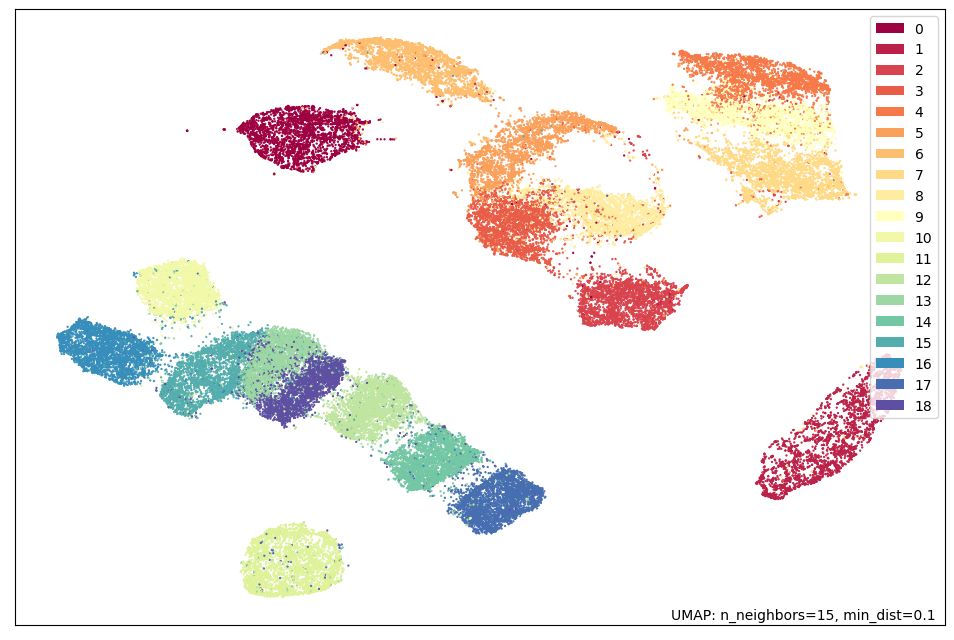

In [20]:
mapper = umap.UMAP().fit(pd.DataFrame(latent_repr.detach()))
umap.plot.points(mapper, labels=np.array(label_dataset), width=1200)

## Latent Adder (LAd)

In [21]:
class LatentAdder(nn.Module):
    def __init__(self, latent_dimensionality):
        super(LatentAdder, self).__init__()

        self.input_size = 2*latent_dimensionality # TODO 2 zu N generalisieren
        self.hidden_size = 3*latent_dimensionality#int(3/2*latent_dimensionality)
        self.output_size = latent_dimensionality
       
        self.stack = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size)
        )
 
    def forward(self, x):
        return self.stack(x)

In [22]:
def make_batch_for_lad(model_vae, number_max=18, number_width=2, batch_size=64, return_labels=False): # TODO generalisieren!!
    X = []
    y = []
    y_int = []
    for _ in range(batch_size):
        
        random_number_1 = random.randint(0, 9)
        random_number_2 = random.randint(0, 9)
        random_sum = random_number_1 + random_number_2

        n1_image = make_image(random_number_1, number_width=number_width)
        n2_image = make_image(random_number_2, number_width=number_width)
        sum_image = make_image(random_sum, number_width=number_width)
        
        n1_latent, _ = model_vae.encode(n1_image.view(1, 28*28*2))
        n2_latent, _ = model_vae.encode(n2_image.view(1, 28*28*2))
        sum_latent, _ = model_vae.encode(sum_image.view(1, 28*28*2))

        X.append(torch.cat([n1_latent, n2_latent], dim=1))
        y.append(sum_latent)
        y_int.append(random_sum)
    
    if return_labels:
        return torch.cat(X), y_int
    return torch.cat(X), torch.cat(y)

In [23]:
blaX, blay = make_batch_for_lad(model_vae)
print('X:', blaX.shape)
print('y:', blay.shape)

X: torch.Size([64, 20])
y: torch.Size([64, 10])


In [24]:
def train_lad(model_vae, batch_count, loss_function, batch_size=64, learning_rate=1e-3, width=800, latent_dimensionality=40): # TODO generalisieren auf number_width

    # Create model
    model = LatentAdder(latent_dimensionality=model_vae.latent_dimensionality)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Save loss values for analysing
    loss_list = []

    # Start training
    for _ in tqdm(range(batch_count)):
        X, y = make_batch_for_lad(model_vae, batch_size=batch_size) # TODO generalisieren

        optimizer.zero_grad()
        y_pred = model(X)

        loss = loss_function(y_pred, y)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()

    return model, loss_list

In [25]:
model_lad, loss_list = train_lad(model_vae, 3_000, nn.MSELoss(), batch_size=128)

100%|██████████| 3000/3000 [38:59<00:00,  1.28it/s] 


<AxesSubplot:>

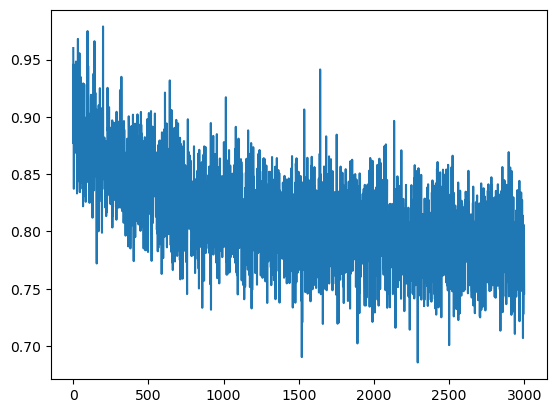

In [26]:
pd.Series(torch.tensor(loss_list)).plot()

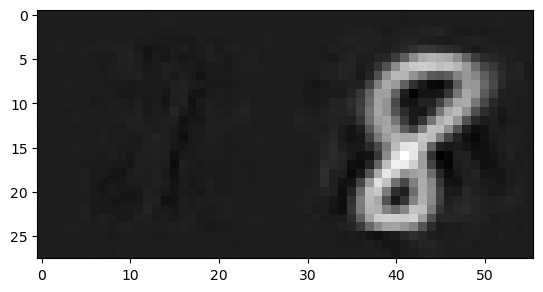

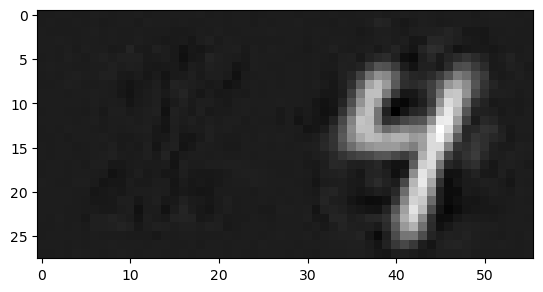

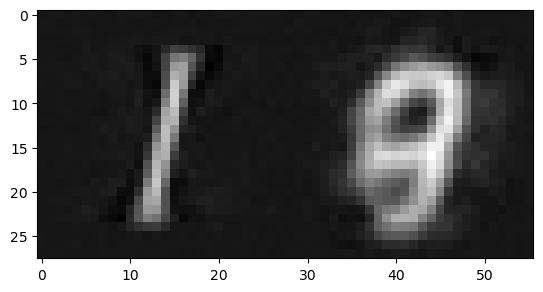

In [27]:
n1, n2 = make_image(8), make_image(4)

n1_latent, _ = model_vae.encode(n1.view(1, 28*28*2))
n2_latent, _ = model_vae.encode(n2.view(1, 28*28*2))

plt.imshow(model_vae.decode(n1_latent).detach().view(1, 28, 28*2).permute(1, 2, 0), cmap='gist_gray')
plt.show()
plt.imshow(model_vae.decode(n2_latent).detach().view(1, 28, 28*2).permute(1, 2, 0), cmap='gist_gray')
plt.show()

latents = torch.cat([n1_latent, n2_latent], dim=1)
sum_latent = model_lad(latents)

plt.imshow(model_vae.decode(sum_latent).detach().view(1, 28, 28*2).permute(1, 2, 0), cmap='gist_gray')
plt.show()

## UMAP Visualization (LAd)

In [28]:
X, y_label = make_batch_for_lad(model_vae, batch_size=10_000, return_labels=True)

In [29]:
y_latent_pred = model_lad(X)
print(y_latent_pred.shape)
print(len(y_label))

torch.Size([10000, 10])
10000


<AxesSubplot:>

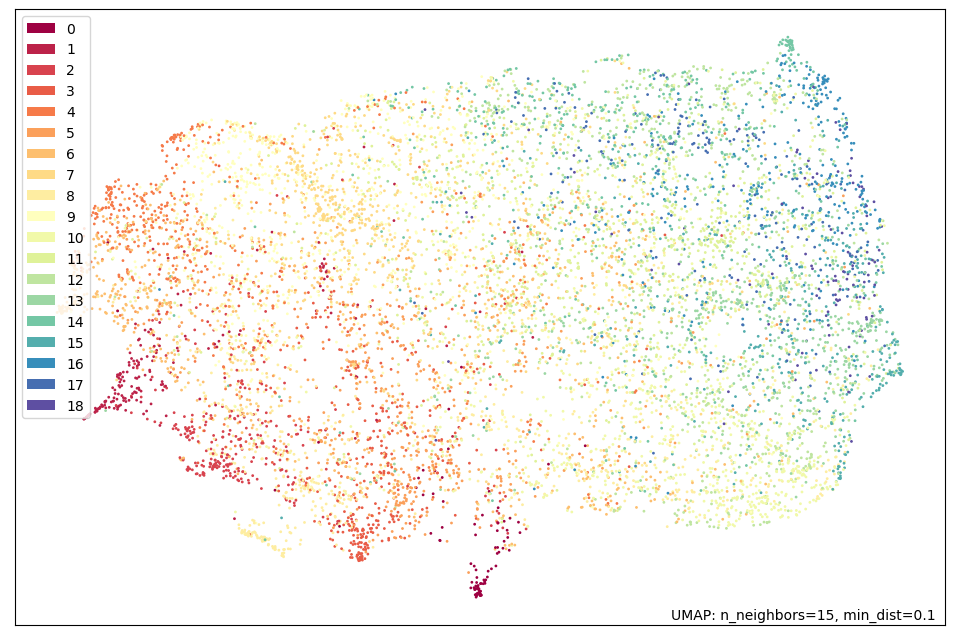

In [30]:
mapper = umap.UMAP().fit(pd.DataFrame(y_latent_pred.detach()))
umap.plot.points(mapper, labels=np.array(y_label), width=1200)